<a href="https://colab.research.google.com/github/spoupry/Hello-world/blob/main/Algo_complet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
from pathlib import Path
import os.path
import numpy as np 
import matplotlib.pyplot as plt
from statsmodels.nonparametric.kernel_regression import KernelReg
import statistics

from google.colab import drive
drive.mount('/content/drive')
dir_path = '/content/drive/My Drive/Colab Notebooks/'
#pour les dates
from datetime import datetime, timedelta
from dateutil.parser import parse

Mounted at /content/drive


In [284]:
# Loading data from csv file
df = pd.read_csv(dir_path + "pm10_daily.csv", delimiter="\t")
# All data in the dataset is in string format. Here we convert them into useful datatypes
df["DateTime"] = pd.to_datetime(df["DateTime"])
# df["Arg12b1f"] = pd.to_numeric(df["Arg12b1f"])
# df["ENI0122B1V1"] = pd.to_numeric(df["ENI0122B1V1"])
# df["ENI0122B2V1"] = pd.to_numeric(df["ENI0122B2V1"])
# print(df.dtypes) # affiche les types du df
# print(df.columns) # columns acces
# print(df.columns[0]) 
df.head(2)

,DateTime,Arg12b1f,ENI0122B1V1,ENI0122B2V1
0,2022-03-02 08:22:00,NaN,35.7,42.8
1,2022-03-02 08:22:00,36.2,NaN,NaN


In [285]:
# initialisation dataset
#Setting the timestamp as index of the dataframe. 
df.set_index('DateTime', inplace=True) #DateTime is now the index. 
# add columns
# df["X1"] = '' 
# df["X2"] = '' 
# df["X3"] = '' 
df.head(2)

,Arg12b1f,ENI0122B1V1,ENI0122B2V1
DateTime,,,
2022-03-02 08:22:00,NaN,35.7,42.8
2022-03-02 08:22:00,36.2,NaN,NaN


In [326]:
# Initialisation variables
StartTime_df = df.index[0]  # Starting timestamp dataset
EndTime_df = df.index[-1]   # End timestamp dataset
tau = timedelta(minutes=20) # step size for rolling window
StepTime = StartTime_df + tau  #slice of time
Threshold = 25 #  15% bonds for outliers
X1raw = pd.Series( [0] , index = [StartTime_df], dtype=float)
X2raw = pd.Series( [0] , index = [StartTime_df], dtype=float)
X3raw = pd.Series( [0] , index = [StartTime_df], dtype=float)
print("Start df",StartTime_df,"End df",EndTime_df,"step",StepTime)
# initialise global series (4)
# Median for row datas
Median = pd.DataFrame( index = [StartTime_df], columns=['Median','MedMax','MedMin'],dtype=float)
# Output after median voter
Outagg = pd.Series([0], index = [StartTime_df], dtype=float)
# Alert from no data detection
Alert = pd.Series( ['Begin'] , index = [StartTime_df])
# Outliers series corresponding SmS
X1out = pd.Series( [0] , index = [StartTime_df], dtype=float)
X2out = pd.Series( [0] , index = [StartTime_df], dtype=float)
X3out = pd.Series( [0] , index = [StartTime_df], dtype=float)
# Reliable series extracted from Median 
X1r = pd.Series( [0] , index = [StartTime_df], dtype=float)
X2r = pd.Series( [0] , index = [StartTime_df], dtype=float)
X3r = pd.Series( [0] , index = [StartTime_df], dtype=float)

Start df 2022-03-02 08:22:00 End df 2022-03-02 20:18:00 step 2022-03-02 08:42:00


# functions

In [314]:
def calculate_median(l):
    l = sorted(l)
    l_len = len(l)
    if l_len < 1:
        return None
    if l_len % 2 == 0 :
        return ( l[(l_len)//2] + l[(l_len//2)-1] ) / 2.0
    else:
        return l[(l_len-1)//2]

#l = [1,2,3,4,5,6]
#print(calculate_median(l)) 

In [315]:
def detect_no_data(X1,X2,X3):
    #detection no Data
    print("Start detection hardware fault")
    HardwareFault=[]
    #print("size of series X1,X2,X3 =",len(X1),len(X2),len(X3))
    if (len(X1) == 0): 
      #print("Hardware fault SmS1")
      HardwareFault.append("Hardware Fault SmS1")
    if (len(X2) == 0): 
      #print("Hardware fault SmS2")
      HardwareFault.append("Hardware Fault SmS2")
    if (len(X3) == 0): 
      #print("Hardware fault SmS3")
      HardwareFault.append("Hardware Fault SmS3")
    if (len(HardwareFault) == 0):
      print("All sensors is ok")
    else:
      print(HardwareFault," Ic= ", 3 - len(Alert.loc[StepTime]),"/3")     
    #Store Hardware fault in Alert serie
    Alert.loc[StepTime] = HardwareFault
    print("End detection hardware fault")

In [316]:
def detect_outliers(X1,X2,X3,Concat):
    print("Start ouliers detection & store")
    #evaluate median and calculate MedMax and MedMin for outlier detection
    Median_slice = np.median(np.array(Concat))
    print(calculate_median(Concat))
    MedMin = Median_slice - (Median_slice*Threshold)/100
    MedMax = Median_slice + (Median_slice*Threshold)/100
    #store median for graphics in Median serie
    Median.loc[StepTime,'Median'] = Median_slice 
    Median.loc[StepTime,'MedMin'] = MedMin 
    Median.loc[StepTime,'MedMax'] = MedMax 
    print("Median",Median_slice,"MedMin",MedMin,"MedMax",MedMax)
    #sOutputs function: X reliable data series
    X1rl = [] 
    X2rl = []
    X3rl = []
    idx_1rl= []      
    idx_2rl= [] 
    idx_3rl= [] 
    # Outliers and reliable of X1
    if(len(X1) != 0):     
      for time, row in X1.iteritems():
        if((row > MedMax) or (row < MedMin)):
          X1out.loc[time] = row 
        else:
          X1r.loc[time] = row #store in global X1r serie for graphics
          X1rl.append(row)    
          idx_1rl.append(time)
    # print(X1)
    # print(X1out)
    # print(X1r)
    # Outliers and reliable of X2
    if(len(X2) != 0):
      for time, row in X2.iteritems():
          if((row > MedMax) or (row < MedMin)):
            X2out.loc[time] = row 
          else:
            X2r.loc[time] = row #store in global X1r serie for graphics
            X2rl.append(row)   
            idx_2rl.append(time)
    # print(X2)
    # print(X2out)
    # print(X2r)
    # Outliers and reliable of X3
    if(len(X3) != 0):
      for time, row in X3.iteritems():
        if((row > MedMax) or (row < MedMin)):
          X3out.loc[time] = row 
        else:
          X3r.loc[time] = row #store in global X1r serie for graphics
          X3rl.append(row)   
          idx_3rl.append(time)
    # print(X3)
    # print(X3out)
    # print(X3r)
    # construct series from lists
    X1rl = pd.Series(X1rl, index = idx_1rl, dtype=float)
    X2rl = pd.Series(X2rl, index = idx_2rl, dtype=float)
    X3rl = pd.Series(X3rl, index = idx_3rl, dtype=float)
    print("End outliers detection & store")
    return X1rl,X2rl,X3rl

In [317]:
def filtering(X1,X2,X3):
  from numpy import linspace
  print("Start filtering")
  #X1
  # Must have two points minimum
  if(len(X1) == 0 or len(X1) == 1):
    X1f = X1
    print("not enough data")
  else:
    X1_ = X1.copy()
    X1_.index = linspace(1., len(X1_),len(X1_))
    kr = KernelReg([X1_.values],[X1_.index.values], var_type='c')
    f1 = kr.fit([X1_.index.values])
    X1f = pd.Series(data=f1[0], index = X1.index, dtype=float)
  #X2
  # Must have two points minimum
  if(len(X2) == 0 or len(X2) == 1):
    X2f = X2
    print("not enough data")
  else:    
    X2_ = X2.copy()
    X2_.index = linspace(1., len(X2_),len(X2_))
    kr = KernelReg([X2_.values],[X2_.index.values], var_type='c')
    f2 = kr.fit([X2_.index.values])
    X2f = pd.Series(data=f2[0], index = X2.index, dtype=float)
  #X3
  # Must have two points minimum
  if(len(X3) == 0 or len(X3) ==1):
    X3f = X3
    print("not enough data")
  else:
    X3_ = X3.copy()
    X3_.index = linspace(1., len(X3_),len(X3_))
    kr = KernelReg([X3_.values],[X3_.index.values], var_type='c')
    f3 = kr.fit([X3_.index.values])
    X3f = pd.Series(data=f3[0], index = X3.index, dtype=float)
  
  print("End filtering")
  # Return filtered data

  return X1f,X2f,X3f


In [291]:
def Median_voter(X1,X2,X3):
  print("Start Median Voter")
  concatenated_series=pd.concat([X1,X2,X3])
  #print(concatenated_series)
  Output = calculate_median(concatenated_series)
  print("Output=",Output)
  print("End Median Voter")
  # Return synthesis of median voter
  return Output

In [318]:
def processing(df):
    print("Start processing slice")
    #create X1,X2,X3 series   
    X1 = [] 
    X2 = []
    X3 = []
    idx_1= []       #stocke les valeurs burtes pour futures détections
    idx_2= [] 
    idx_3= [] 
    for time, row in df.iterrows():
      if(pd.isna(row[df.columns[0]]) == False ):      #teste si il y a  NaN  
        X1.append(row[df.columns[0]])   #stock in x1 list
        idx_1.append(time)
        X1raw.loc[time] = row[df.columns[0]]     #input in X1raw serie
      if(pd.isna(row[df.columns[1]]) == False ): 
        X2.append(row[df.columns[1]]) 
        idx_2.append(time)
        X2raw.loc[time] = row[df.columns[1]]     #input in X2raw serie            
      if(pd.isna(row[df.columns[2]]) == False ):
        X3.append(row[df.columns[2]])
        idx_3.append(time)
        X3raw.loc[time] = row[df.columns[2]]     #input in X3raw serie
    #Traitements à partir du premier passage
    #print(X1,X2,X3)

    Concat = X1 + X2 + X3
    # create series             
    X1 = pd.Series(X1, index = idx_1, dtype=float)
    X2 = pd.Series(X2, index = idx_2, dtype=float)
    X3 = pd.Series(X3, index = idx_3, dtype=float)
    print("X1,X2 and X3 created")
    # Function detection hardware fault
    detect_no_data(X1,X2,X3)
    # Function detection outliers + stock values in Xout series 
    Xreliable = detect_outliers(X1,X2,X3,Concat) # return reliable data (Xr)
    # print(Xreliable)
    # Function kernel regression return filtered data (Xrf)
    Xfiltered = filtering(Xreliable[0],Xreliable[1],Xreliable[2])
    # Function Median voter
    Output = Median_voter(Xfiltered[0],Xfiltered[1],Xfiltered[2])
    # Store ouput in the Outagg serie
    if(Output == None): 
      print("oh la la")
    else:
      Outagg.loc[StepTime] = Output
    #return X1,X2,X3

In [293]:
def affiche(X1,X2,X3,Median):
  print("Start graphics")
  print("lens of series =",len(X1),len(X2),len(X3))
  # affichage series
  plt.figure(figsize=(12,8))
  X1.plot(label='1')
  X2.plot(label='2')
  X3.plot(label='3')
  plt.fill_between(Median.index,Median['MedMax'],Median['MedMin'],alpha = 0.2, label='Median bonds')
  plt.legend()
  plt.show()


# Slicer dataframe


In [327]:
# first slice of time from df
StepTime = StartTime_df + tau
Time_slice_list=[StartTime_df ]
print("Start: ", StartTime_df, " , End: ", StepTime)
# Identificate the first slice
df_slice = df.loc[StartTime_df:StepTime].copy()
#processing slice
processing(df_slice)
Median.loc[StartTime_df] = Median.loc[StepTime]
# print(Median)
#affiche(X1raw,X2raw,X3raw,Median)
#affiche(X1out,X2out,X3out,Median)

Start:  2022-03-02 08:22:00  , End:  2022-03-02 08:42:00
Start processing slice
X1,X2 and X3 created
Start detection hardware fault
All sensors is ok
End detection hardware fault
Start ouliers detection & store
18.2
Median 18.2 MedMin 13.649999999999999 MedMax 22.75
End outliers detection & store
Start filtering
not enough data
End filtering
Start Median Voter
Output= 16.697777312623785
End Median Voter


In [328]:
# others slices
for time, row in df.iterrows():
  if(time <= StepTime):
    This_time = time
    #print(time)  
  if(time > StepTime):
    Start_step = time
    StepTime = time + tau
    Time_slice_list.append(Start_step)
    #Time_slice_list.append(StepTime)
    print("Start: ", Start_step, " , End: ", StepTime)
    df_slice = df.loc[Start_step:StepTime].copy()
    processing(df_slice)
    #print(df_slice.head(1))
    #print(df_slice.tail(1))

#Time_slice_list

Start:  2022-03-02 08:47:00  , End:  2022-03-02 09:07:00
Start processing slice
X1,X2 and X3 created
Start detection hardware fault
All sensors is ok
End detection hardware fault
Start ouliers detection & store
6.4
Median 6.4 MedMin 4.800000000000001 MedMax 8.0
End outliers detection & store
Start filtering
End filtering
Start Median Voter
Output= 6.4
End Median Voter
Start:  2022-03-02 09:10:00  , End:  2022-03-02 09:30:00
Start processing slice
X1,X2 and X3 created
Start detection hardware fault
All sensors is ok
End detection hardware fault
Start ouliers detection & store
4.2
Median 4.2 MedMin 3.1500000000000004 MedMax 5.25
End outliers detection & store
Start filtering
End filtering
Start Median Voter
Output= 3.8968377173196584
End Median Voter
Start:  2022-03-02 09:33:00  , End:  2022-03-02 09:53:00
Start processing slice
X1,X2 and X3 created
Start detection hardware fault
All sensors is ok
End detection hardware fault
Start ouliers detection & store
8.5
Median 8.5 MedMin 6.375 Me

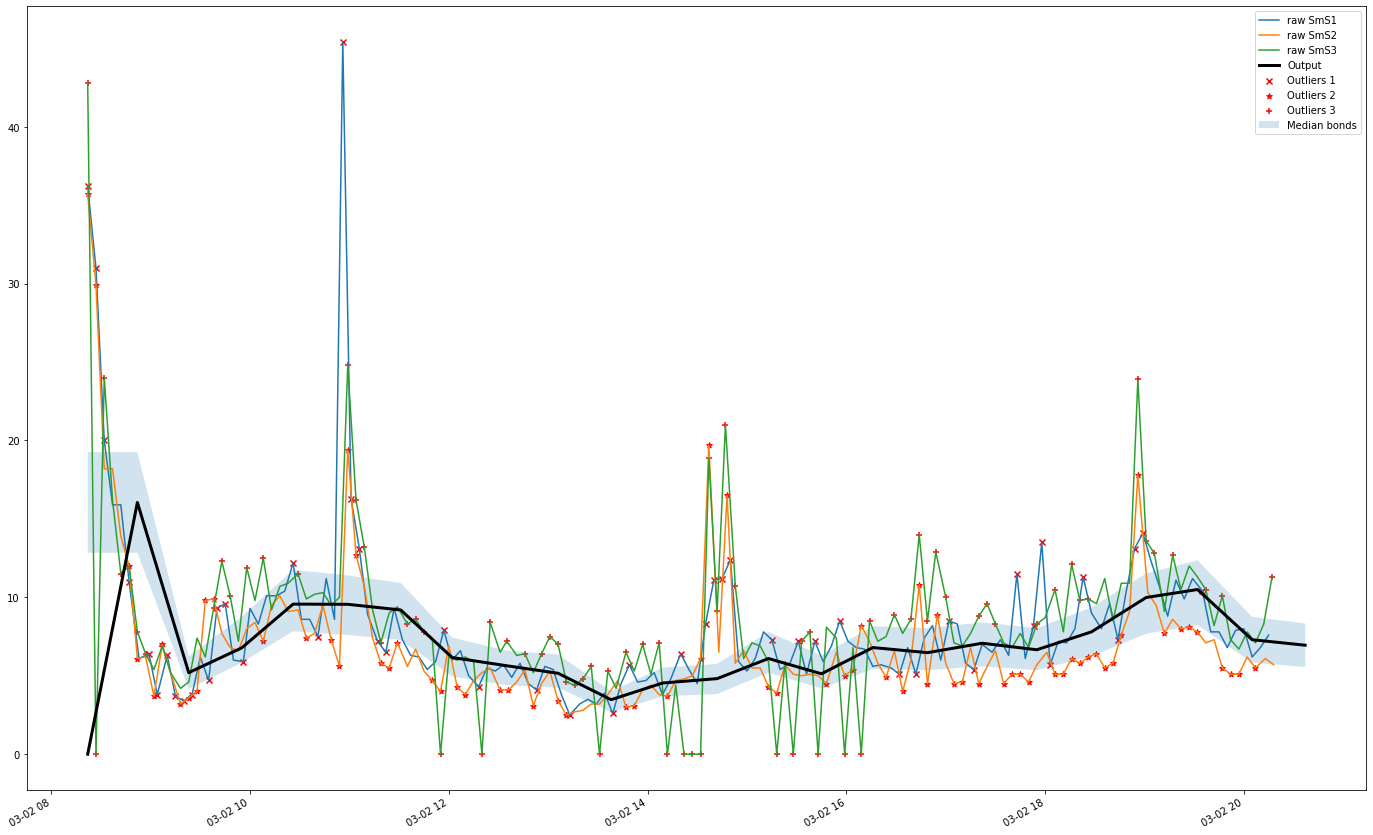

In [325]:
# affiche(X1raw,X2raw,X3raw,Median)
  # affichage series
plt.figure(figsize=(24,16))
plt.scatter(X1out.index, X1out.values,label='Outliers 1', c='red' ,marker = 'x')
plt.scatter(X2out.index, X2out.values,label='Outliers 2', c='red' ,marker = '*')
plt.scatter(X3out.index, X3out.values,label='Outliers 3', c='red' ,marker = '+')
X1raw.plot(label='raw SmS1')
X2raw.plot(label='raw SmS2')
X3raw.plot(label='raw SmS3')
plt.fill_between(Median.index,Median['MedMax'],Median['MedMin'],alpha = 0.2, label='Median bonds')
Outagg.plot(label='Output', linewidth = 3, c='black' )
plt.legend()
plt.show()